# Feature visualization on GoogleNet trained on the ImageNet dataset

## Imports

### Basics

In [1]:
import torch
from torchvision.transforms import v2
import torchvision.models as models
import matplotlib.pyplot as plt 
import imageio
import glob
import shutil
import os, sys

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# For local imports (from "scripts")
project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

Here, we will perform feature visualization on the GoogleNet model (22 layers deep), an image classifier trained on the ImageNet dataset.

In [3]:
# The GoogleNet model
googlenet = models.googlenet(pretrained=True).to(device)
googlenet.eval();

c:\Users\mante\Documents\GitHub\audio-neural-dissection\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mante\Documents\GitHub\audio-neural-dissection\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The last layer of the classifier is a *softmax* function performed on a vector of dimension 1000 (for the 1000 available classes). The different classes (and their ID) are availabke [here](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/). We will rely on this list to know which role has every last-layer neuron.

### Objective

The `Objective` class lets us define what we aim to maximize. This can point to a neuron, a channel or a layer. It will be fed to the *activation maximizer* for the maximizing process.

The `layer_out` global variable is used to extract the state of the objective from inside the model during the training process.

In [4]:
from scripts.visualization.optimization_tools import Objective

layer_out = None

LAYER_OBJ = 1
CHANNEL_OBJ = 2
NEURON_OBJ = 3

### Activation maximizer

The `ActivationMaximizer` class provides the `optimize` function that trains the model to maximize the *objective* we have defined. Ths output of the maximization process is then the optimal model input for activating the *objective*.

In [5]:
from scripts.visualization.optimization_tools import GoogleNetActivationMaximizer

## GoogleNet

c:\Users\mante\Documents\GitHub\audio-neural-dissection\venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:58<00:00, 16.90it/s]


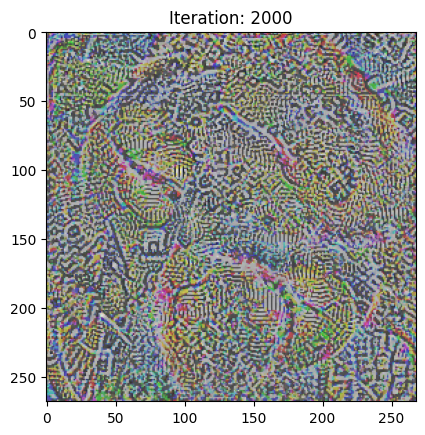

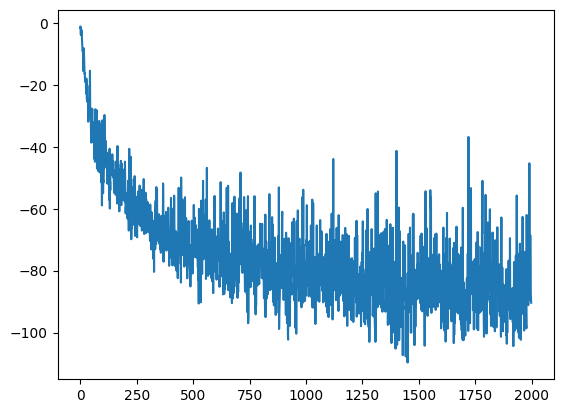

In [6]:
preprocess = v2.Compose([
    v2.Resize(224*2),
    v2.ToTensor()
])

transforms = [
    # v2.RandomAffine(0, translate=(0.01, 0.01)),
    # v2.RandomAffine(0, scale=(0.99, 1/0.99)),
    v2.RandomRotation(interpolation=v2.InterpolationMode.BILINEAR, degrees=(-0.1, 0.1)),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.GaussianBlur(5, sigma=(1, 2)),
    v2.ColorJitter(brightness=0.2, saturation=[0.8, 1.3], hue=0.1, contrast=[0.8, 1.3])
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip()
]

objective = Objective(NEURON_OBJ, googlenet.fc, neuron_index=852)
maximizer = GoogleNetActivationMaximizer(googlenet, (1, 3, 224, 224))

start, result, loss_history = maximizer.optimize(
    objective=objective, 
    transforms=transforms, 
    iterations=2000,
    eta=50,
    loss_func=lambda x: -torch.sum(torch.abs(x)), #-torch.sum(x**2),
    reg=0,
    plot_period=50,
    save=True,
    plot_inline=False,
    device=device,
)

plt.figure()
plt.plot(loss_history)
plt.show()

In [7]:
output = googlenet(result.to(device))

_, indices = torch.topk(output, 3)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
for i in indices[0]:
    print(f"{i}: {percentage[i].item():.2f}%")

714: 19.69%
156: 9.42%
369: 8.56%


In [8]:
file_names = glob.glob("output/im*.png")
if len(file_names) > 0:
    images = []
    file_gen = glob.iglob("output/im*.png")
    for f_name in file_gen:
        images.append(imageio.imread(f_name))
    imageio.mimsave("output_epochs.gif", images)
    
    shutil.copyfile(file_names[-1], "output.png")
    
shutil.rmtree("output")

C:\Users\mante\AppData\Local\Temp\ipykernel_21256\1118380582.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f_name))


In [9]:
# import torch

# # Load pre-trained GoogleNet model

# import torchvision.models as models
# googlenet = models.googlenet(pretrained=True)
# googlenet.eval()

# # Set the model to evaluation mode


# # Load and preprocess an image for inference
# image_path = 'sax-test.jpg'
# input_image = Image.open(image_path)
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# # Perform inference
# output = googlenet(input_batch)

# # Display the top 3 predictions
# _, indices = torch.topk(output, 3)
# percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
# for i in indices[0]:
#     print(f"{i}: {percentage[i].item():.2f}%")